In [1]:
import torch
from torch import FloatTensor
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from tools import *
plt.rcParams['figure.figsize'] = (10,7)
%matplotlib inline

In [2]:
class DiscriminatorNet(torch.nn.Module):                                                                
    def __init__(self, n_in, n_hidden0, n_hidden1, n_hidden2, n_out):                          
        super(DiscriminatorNet, self).__init__()                                                        
        self.hidden0 = torch.nn.Linear(n_in, n_hidden0)                                        
        self.hidden1 = torch.nn.Linear(n_hidden0, n_hidden1)                                         
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)
        self.out     = torch.nn.Linear(n_hidden2, n_out)

    def forward(self, x):
        x = torch.nn.LeakyReLU(0.2)(self.hidden0(x))
        x = torch.nn.Dropout(0.3)(x)
        x = torch.nn.LeakyReLU(0.2)(self.hidden1(x))
        x = torch.nn.Dropout(0.3)(x)
        x = torch.nn.LeakyReLU(0.2)(self.hidden2(x))
        x = torch.nn.Dropout(0.3)(x)
        x = self.out(x)
        return x
    
class GeneratorNet(torch.nn.Module):
    def __init__(self, n_in, n_hidden0, n_hidden1, n_hidden2, n_out):
        super(GeneratorNet, self).__init__()
        assert(n_in == n_out)
        self.hidden0 = torch.nn.Linear(n_in, n_hidden0)                                        
        self.hidden1 = torch.nn.Linear(n_hidden0, n_hidden1)                                         
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)
        self.out     = torch.nn.Linear(n_hidden2, n_out)

    def forward(self, x):
        x = torch.nn.LeakyReLU(0.2)(self.hidden0(x))
        x = torch.nn.LeakyReLU(0.2)(self.hidden1(x))
        x = torch.nn.LeakyReLU(0.2)(self.hidden2(x))
        x = self.out(x)
        return x

In [3]:
train = np.genfromtxt('data/scene-train.data', delimiter=',')
test = np.genfromtxt('data/scene-test.data', delimiter=',')

Xtr, ytr = train[:,:-6], train[:,-7].reshape(-1,1)
Xtst, ytst = test[:,:-6], test[:,-7].reshape(-1,1)
m, n = Xtr.shape
N = 1
print(n)

294


test loss 
 0.3385
[torch.FloatTensor of size 1]



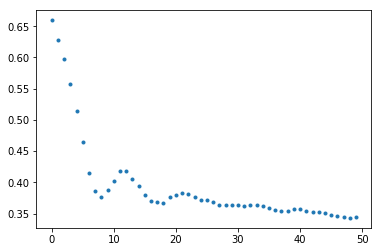

In [4]:
model = DiscriminatorNet(n, 256, 128, 64, N)        
train_losses, test_loss = classification_traintest(model, Xtr, ytr, Xtst, ytst)
plt.plot(train_losses,'.')
print("test loss", test_loss.data)

## Train the GAN

$$ \max_G \min_D \| D(G(x)) - y \|_2^2 - \| x - G(x) \|_2^2$$

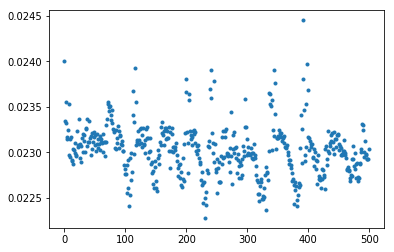

In [5]:
D = DiscriminatorNet(n, 256, 128, 64, 1)     
G = GeneratorNet(n, 256, 64, 256, n)
D_opt = torch.optim.Adam(D.parameters())
G_opt = torch.optim.Adam(G.parameters())
criterion = torch.nn.MSELoss()

epochs = 500
D_losses_raw = []
D_losses_clean = []
for epoch in range(epochs):
    X = Variable(torch.FloatTensor(Xtr))
    y = Variable(torch.FloatTensor(ytr[:,0].reshape(-1,1)))
    
    X_tild = G(X)
    y_tild = D(X_tild)
    
    D.zero_grad()
    D_loss = criterion(y_tild, y)
    D_losses_clean.append(D_loss.data[0])
    D_loss.backward(retain_graph = True)
    D_opt.step()
    
    G.zero_grad()
    G_loss = -criterion(y_tild, y)+criterion(X_tild, X)
    G_loss.backward()
    G_opt.step()
    
plt.plot(D_losses_clean,'.')
Xtr, ytr = train[:,:-6], train[:,-6].reshape(-1,1)
Xtst, ytst = test[:,:-6], test[:,-6].reshape(-1,1)

In [9]:
Xtr, ytr = train[:,:-6], train[:,-7].reshape(-1,1)
Xtst, ytst = test[:,:-6], test[:,-7].reshape(-1,1)

test loss 0.3007133901119232


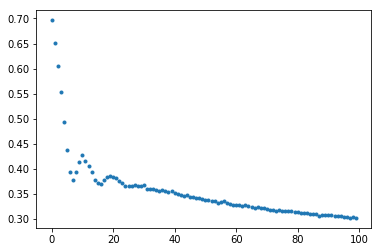

In [16]:
model = DiscriminatorNet(n, 256, 128, 64, N)        
train_losses, test_loss = classification_traintest(model, Xtr, ytr, Xtst, ytst, epochs=100)
plt.plot(train_losses,'.')
print("test loss", test_loss.data[0])

test loss 0.4474179148674011


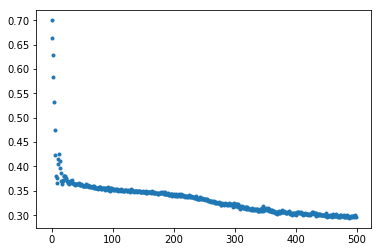

In [19]:
X_hat = G(Variable(FloatTensor(Xtr)))
X_hat = X_hat.data.numpy()
model = DiscriminatorNet(n, 256, 128, 64, N)        
train_losses, test_loss = classification_traintest(model, X_hat, ytr, Xtst, ytst, epochs=500)
plt.plot(train_losses,'.')
print("test loss", test_loss.data[0])